In [0]:
from google.colab import files

uploaded = files.upload()

Saving stock-daily.csv to stock-daily.csv


In [0]:
ls -l


total 84
-rw-r--r-- 1 root root 36957 May 14 01:48 daily-stock.txt
drwxr-xr-x 1 root root  4096 May  8 16:22 sample_data/
-rw-r--r-- 1 root root 36957 May 14 01:49 stock-daily.csv


In [0]:
%matplotlib inline

import tensorflow as tf
import numpy as np
#%matplotlib notebook
import matplotlib.pyplot as plt
import os


tf.reset_default_graph()

In [0]:
#https://finance.yahoo.com/quote/GOOG/history?ltr=1

In [0]:
tf.set_random_seed(777)  # reproducibility

def MinMaxScaler(data):
    ''' Min Max Normalization
    Parameters
    ----------
    data : numpy.ndarray
        input data to be normalized
        shape: [Batch size, dimension]
    Returns
    ----------
    data : numpy.ndarry
        normalized data
        shape: [Batch size, dimension]
    References
    ----------
    .. [1] http://sebastianraschka.com/Articles/2014_about_feature_scaling.html
    '''
    numerator = data - np.min(data, 0)
    denominator = np.max(data, 0) - np.min(data, 0)
    # noise term prevents the zero division
    return numerator / (denominator + 1e-7)

In [0]:

# train Parameters
seq_length = 7
data_dim = 5
hidden_dim = 10
output_dim = 1
learning_rate = 0.01
iterations = 500

In [0]:

# Open, High, Low, Volume, Close
xy = np.loadtxt('stock-daily.csv', delimiter=',' , skiprows = 1)
#xy = np.loads('stock-daily.csv', delimiter=',', skiprows = 1)
xy = xy[::-1]  # reverse order (chronically ordered)

# train/test split
train_size = int(len(xy) * 0.7)
train_set = xy[0:train_size]
test_set = xy[train_size - seq_length:]  # Index from [train_size - seq_length] to utilize past sequence

# Scale each
train_set = MinMaxScaler(train_set)
test_set = MinMaxScaler(test_set)

In [0]:
# build datasets
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series) - seq_length):
        _x = time_series[i:i + seq_length, :]
        _y = time_series[i + seq_length, [-1]]  # Next close price
        #print(_x, "->", _y)
        dataX.append(_x)
        dataY.append(_y)
    return np.array(dataX), np.array(dataY)

In [0]:

trainX, trainY = build_dataset(train_set, seq_length)
testX, testY = build_dataset(test_set, seq_length)

# input place holders
X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y = tf.placeholder(tf.float32, [None, 1])

# build a LSTM network
cell = tf.contrib.rnn.BasicLSTMCell(
    num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(
    outputs[:, -1], output_dim, activation_fn=None)  # We use the last cell's output

In [0]:
# cost/loss
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
# optimizer
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)

# RMSE
targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))

[step: 0] loss: 165.11505126953125
[step: 20] loss: 6.52082633972168
[step: 40] loss: 2.1283316612243652
[step: 60] loss: 1.419877290725708
[step: 80] loss: 1.2835544347763062
[step: 100] loss: 1.2315205335617065
[step: 120] loss: 1.1933298110961914
[step: 140] loss: 1.1554961204528809
[step: 160] loss: 1.1172517538070679
[step: 180] loss: 1.0783408880233765
[step: 200] loss: 1.039210557937622
[step: 220] loss: 1.0006234645843506
[step: 240] loss: 0.9634976387023926
[step: 260] loss: 0.9287034869194031
[step: 280] loss: 0.8968721628189087
[step: 300] loss: 0.8682928681373596
[step: 320] loss: 0.8429286479949951
[step: 340] loss: 0.8205093145370483
[step: 360] loss: 0.8006376624107361
[step: 380] loss: 0.7828717231750488
[step: 400] loss: 0.7667763829231262
[step: 420] loss: 0.7519527673721313
[step: 440] loss: 0.73805832862854
[step: 460] loss: 0.7248163223266602
[step: 480] loss: 0.7120232582092285
RMSE: 0.05130970478057861


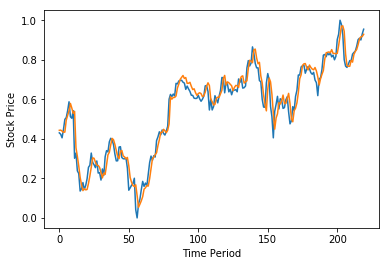

In [0]:

with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={
                                X: trainX, Y: trainY})
        if(i%20 == 0):
          print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = sess.run(Y_pred, feed_dict={X: testX})
    rmse_val = sess.run(rmse, feed_dict={
                    targets: testY, predictions: test_predict})
    print("RMSE: {}".format(rmse_val))

    # Plot predictions
    plt.plot(testY)
    plt.plot(test_predict)
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()